In [28]:
from astropy.io import fits
import glob
import os
import shutil
import numpy as np

# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import fits

from matplotlib import rc
from astropy import wcs
from astropy.io import fits
from astropy import coordinates
from astropy import units as u
from astropy.coordinates import Angle
from astroquery.vizier import Vizier
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename
from matplotlib.patches import Rectangle
from matplotlib.patches import ConnectionPatch
from matplotlib.patches import FancyArrowPatch
from matplotlib.patches import ArrowStyle
import glob
from photutils import *
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats
from astropy.table import Table, vstack
from photutils import DAOStarFinder
from astropy import stats
import math

def get_2mass_ZP(filename, object_coords=None,r=4,aperture_rad=4) :
    """
    Use header to find coords and query 2mass.
    """ 
    #print [RA,DEC]
    
    hdu = fits.open(filename)
    data = hdu[0].data
    wcs = WCS(filename)
    itime = hdu[0].header['EXPTIME']
    RA = hdu[0].header['RA']
    DEC = hdu[0].header['DEC']
    
    annulus_inner_scale = 3
    annulus_outer_scale = 4
    annulus_inner = aperture_rad * annulus_inner_scale
    annulus_outer = aperture_rad * annulus_outer_scale

    gal_coords = coordinates.SkyCoord(RA* u.deg,DEC* u.deg, frame = 'icrs')
    rad = r * u.arcminute  
    Vizier.ROW_LIMIT = -1
    #  Query 2mass. gives output as TableList
    _2mass_query = Vizier.query_region(gal_coords,radius=rad,catalog='2mass')
    # Get the table we want
    _2mass_stars = _2mass_query['II/246/out']    
    coords_mag_array = np.array(_2mass_stars['RAJ2000','DEJ2000', 'Jmag',  'e_Jmag', 'Hmag',  'e_Hmag', 'Kmag', 
                                             'e_Kmag','Xflg'])    
    input_coords = []   
    for item in coords_mag_array :
        if item[4] != 1:
            coords_new = coordinates.SkyCoord(item[0]*u.degree,item[1]*u.degree,frame = 'icrs')
            input_coords.append((coords_new,item)) 
            
    # Need to center the 2mass stars, if astrometry is off
    # 
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)
    daofind = DAOStarFinder(fwhm=4.0, threshold=10.*std)
    sources = daofind(data - median )
    for col in sources.colnames:    
        sources[col].info.format = '%.8g'  # for consistent table output
    #sources.pprint(max_lines=-1, max_width=-1)
    
    #Plotting
    fig = plt.figure(figsize=(10.0, 10.0))
    ax1 = plt.subplot(1,1,1,projection=wcs)
    ax1.imshow(data, clim=(-100, 100),cmap='gray_r')
    ax1.set_autoscale_on(False)
    
    phot_table = []
    for item in input_coords :
        # For each position, define aperture and use the image WCS to convert to pixel coords
        # Define an annulus for skysub at the same position and also convert
        aperture = SkyCircularAperture(item[0], r = aperture_rad * u.arcsec)
        annulus_aperture = SkyCircularAnnulus(item[0], r_in= annulus_inner * u.arcsec, r_out= annulus_outer* u.arcsec)
        pix_aperture = aperture.to_pixel(wcs)
        pix_annulus_aperture = annulus_aperture.to_pixel(wcs)
        #If the aperture is outside the image FoV, skip
        if pix_aperture.positions[0][0] < 0 or pix_aperture.positions[0][1] < 0:
            continue
        # If the aperture is close to the galaxy, skip. These galaxy often have lots of 2mass sources in the cat
        #gal_coords = coordinates.SkyCoord(galaxy_coords[0]* u.deg,galaxy_coords[1]* u.deg, frame = 'icrs')
        #print gal_coords
        #sep = gal_coords.separation(item[0])
        #if sep.arcminute < 1 :
        #    continue  
        #Before the rest, center by comparing the pix coords with the DAOfind results and replacing if close
        #print pix_aperture.positions
        for i in range(0,len(sources)) :
            if (abs(pix_aperture.positions[0][0] - sources['xcentroid'][i]) < 30 and 
                       abs(pix_aperture.positions[0][1] - sources['ycentroid'][i]) < 30) :
                pix_aperture.positions[0][0] = sources['xcentroid'][i]
                pix_annulus_aperture.positions[0][0] = sources['xcentroid'][i]
                pix_aperture.positions[0][1] = sources['ycentroid'][i]  
                pix_annulus_aperture.positions[0][1] = sources['ycentroid'][i]  
                #print 'centred: ', pix_aperture.positions
                
        pix_aperture.plot(edgecolor='xkcd:white')
        pix_annulus_aperture.plot(edgecolor='xkcd:red')
        # You have to make a mask, which is just 0's and 1's defining the annulus pixels
        pix_annulus_mask = pix_annulus_aperture.to_mask(method='center')
        # This multiplies the whole image data by the mask, i.e gives a 2D "image" of the annulus
        try :
            pix_annulus_data = pix_annulus_mask[0].multiply(data)
        except TypeError :
            continue
        # linearise the 2D to 1D
        mask = pix_annulus_mask[0].data
        pix_annulus_data_1d = pix_annulus_data[mask > 0]
        # Take a sigma clipped mean in the annulus
        _, median_sigclip, _ = sigma_clipped_stats(pix_annulus_data_1d)
        # Now do the phot
        phot = aperture_photometry(hdu[0], pix_aperture)
        phot['annulus_median'] = median_sigclip
        # aperture background is just the annulus median * area
        phot['aper_bkg'] = median_sigclip * pix_aperture.area() *  u.ct
        # flux is aperture_sum - bg
        phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']     
        phot['mag'] = -2.5 * np.log10(phot['aper_sum_bkgsub'].value/itime)*u.mag 
        phot['RA'] = aperture.positions.ra.degree
        phot['DEC']= aperture.positions.dec.degree
        phot['Kmag_ref'] = item[1][2]*u.mag
        phot['Kmag_ref_err'] = item[1][3]
        #phot.pprint(max_lines=-1, max_width=-1) 
        if phot['aperture_sum'].unit == None:
            continue
        phot_table.append(phot)
    total_table = vstack(phot_table,join_type='outer')
    #print x.pprint(max_lines=-1, max_width=-1) 
    zps = []
    for i in range(0,len(total_table)):
        zp =  total_table['Kmag_ref'][i] - total_table['mag'][i]
        zps.append(zp.value)
        #x['derived_ZP'][i] = zp
        #print zp
    total_table['derived_ZP'] = zps 
    sigmaclip = stats.sigma_clip(np.array(zps),sigma=2,iters=10) 
    
    mean_value = sigmaclip.mean()
    variance = sigmaclip.var()
    std_dev = sigmaclip.std()
    MSE = variance / math.sqrt(sigmaclip.count())
    print "Mean, sigma, number of clips:  ", mean_value, std_dev, abs(sigmaclip.count() - len(np.array(zps)))
    ZP = mean_value   
    print 'The derived ZP is: ', ZP, ' with sigma: ', std_dev
    
    
    return ZP

Mean, sigma, number of clips:   22.8496904767 0.154115784985 2
The derived ZP is:  22.8496904767  with sigma:  0.154115784985
Mean, sigma, number of clips:   23.2838080164 0.0218729655112 4
The derived ZP is:  23.2838080164  with sigma:  0.0218729655112
Mean, sigma, number of clips:   22.6915122677 0.0271519480217 4
The derived ZP is:  22.6915122677  with sigma:  0.0271519480217
22.6915122677


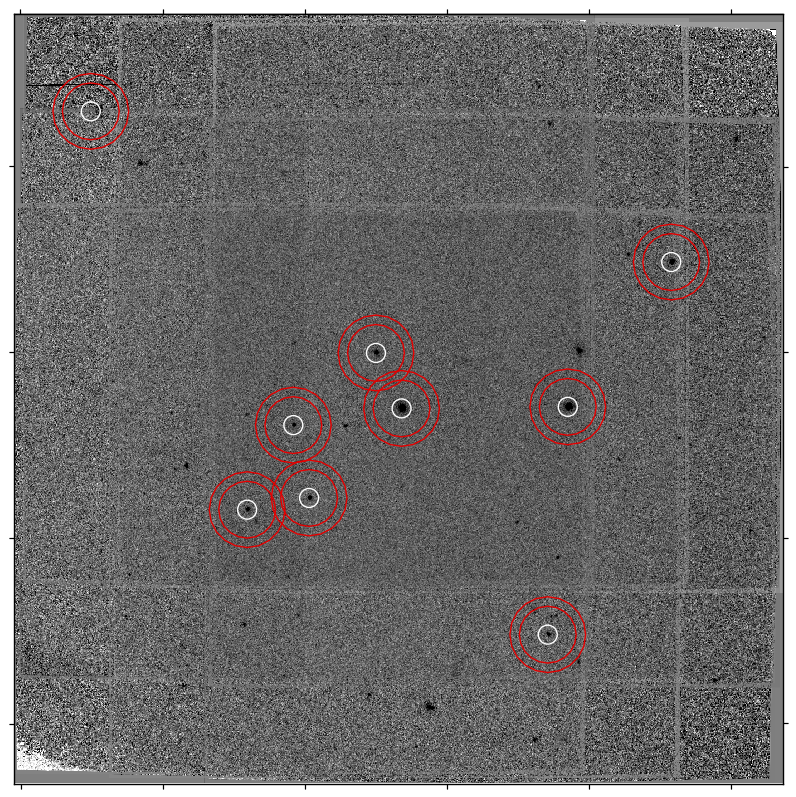

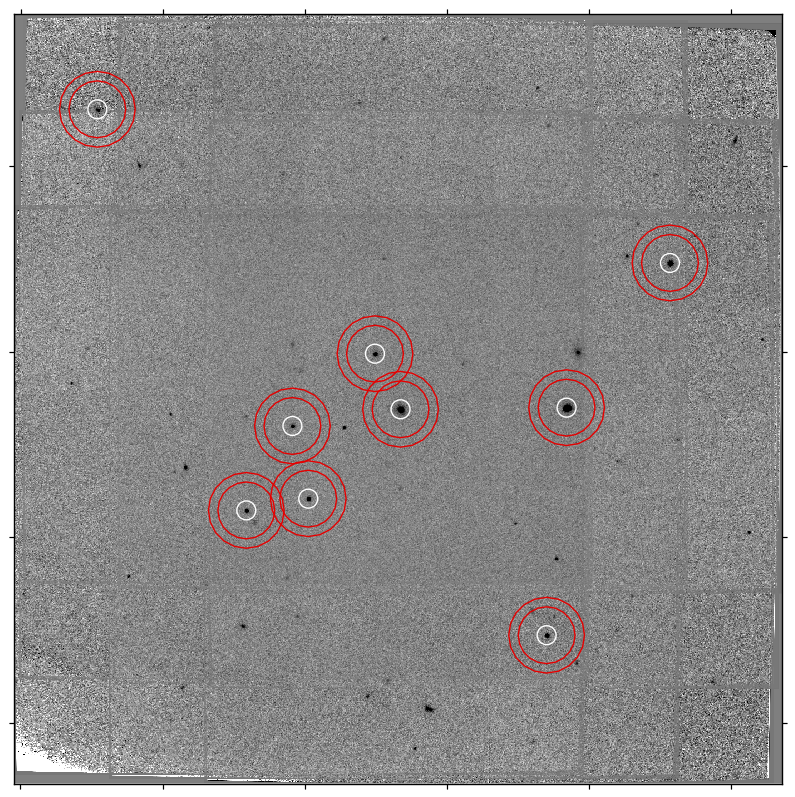

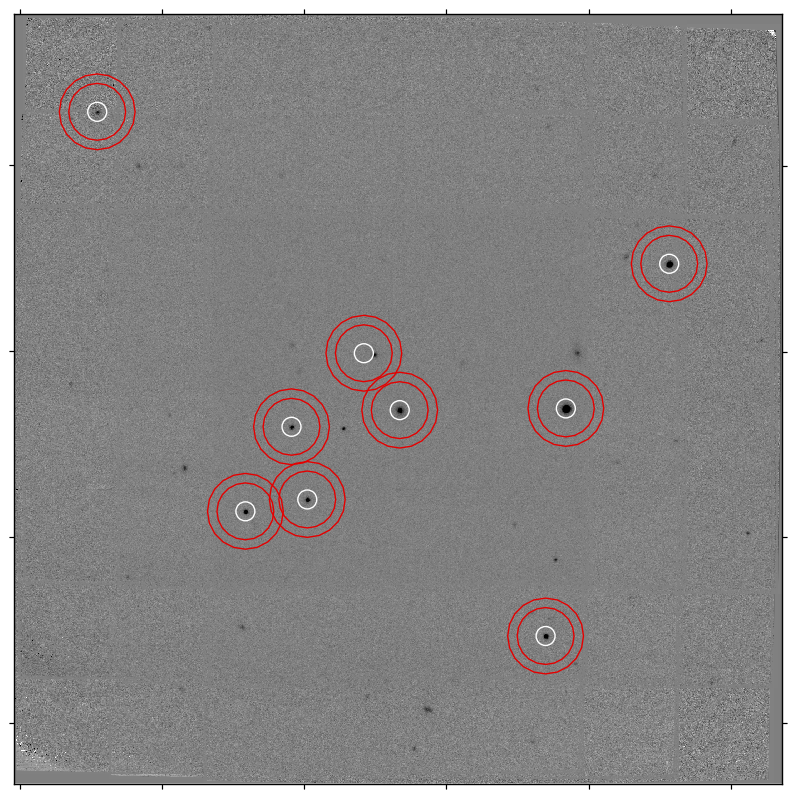

In [30]:
ZP = get_2mass_ZP('/home/treynolds/data/NOTCAM/20160811/Gaia16aax_20160811/Gaia16aax_20160811_K.fits',
             object_coords=None,r=4,aperture_rad=4)

ZP = get_2mass_ZP('/home/treynolds/data/NOTCAM/20160811/Gaia16aax_20160811/Gaia16aax_20160811_H.fits',
             object_coords=None,r=4,aperture_rad=4) 

ZP = get_2mass_ZP('/home/treynolds/data/NOTCAM/20160811/Gaia16aax_20160811/Gaia16aax_20160811_J.fits',
             object_coords=None,r=4,aperture_rad=4) 

print ZP